# Лабораторная работа: Методы искусственного интеллекта
## Задача кластеризации продуктов с использованием cuML
### Вариант: Продукты
В данной работе используется библиотека cuML для GPU-ускоренного анализа данных. Цель: провести кластеризацию продуктов на основе их характеристик.

### Загрузка и исследование данных

In [2]:
import cudf
import cuml
from cuml.preprocessing import LabelEncoder
from cuml.decomposition import PCA
from cuml.cluster import KMeans
import cupy as cp
import matplotlib.pyplot as plt

# Загрузка данных
df = cudf.read_csv('/mnt/d/AIM-PIbd-31-Medvedkov-A-D//data/jio_mart_items.csv')
print(df.info())
print(df.head())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 162313 entries, 0 to 162312
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   category      162313 non-null  object
 1   sub_category  162313 non-null  object
 2   href          162313 non-null  object
 3   items         162280 non-null  object
 4   price         162282 non-null  float64
dtypes: float64(1), object(4)
memory usage: 28.9+ MB
None
    category         sub_category  \
0  Groceries  Fruits & Vegetables   
1  Groceries  Fruits & Vegetables   
2  Groceries  Fruits & Vegetables   
3  Groceries  Fruits & Vegetables   
4  Groceries  Fruits & Vegetables   

                                                href  \
0  https://www.jiomart.com/c/groceries/fruits-veg...   
1  https://www.jiomart.com/c/groceries/fruits-veg...   
2  https://www.jiomart.com/c/groceries/fruits-veg...   
3  https://www.jiomart.com/c/groceries/fruits-veg...   
4  https://www.jiomart.com/

### Предварительная обработка данных

In [3]:
# Обработка пропущенных значений
df = df.dropna()

# Кодирование категориального признака 'items'
label_encoder = LabelEncoder()
df['items_encoded'] = label_encoder.fit_transform(df['items'])

# Нормализация числовых признаков
numeric_features = ['items_encoded', 'price']
df_scaled = df[numeric_features].astype('float32')

# Преобразование данных в формат cupy
X = cp.asarray(df_scaled.values)

### Понижение размерности и визуализация данных

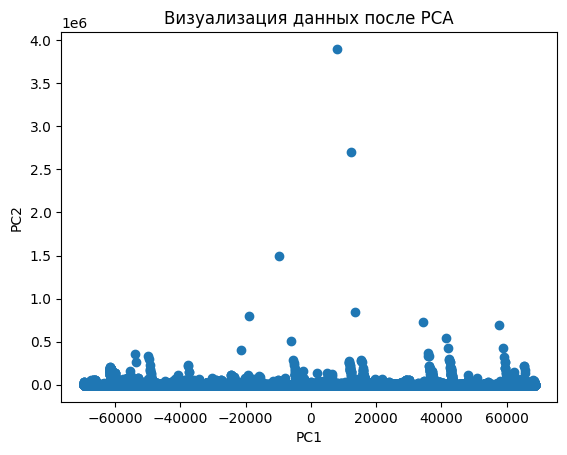

In [4]:
# Применение PCA для понижения размерности
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)

# Преобразуем данные из cupy в numpy
reduced_data_np = reduced_data.get()

# Визуализация данных
plt.scatter(reduced_data_np[:, 0], reduced_data_np[:, 1])
plt.title('Визуализация данных после PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Выбор оптимального количества кластеров

Оценка числа кластеров: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:06<00:00, 40.73s/it]


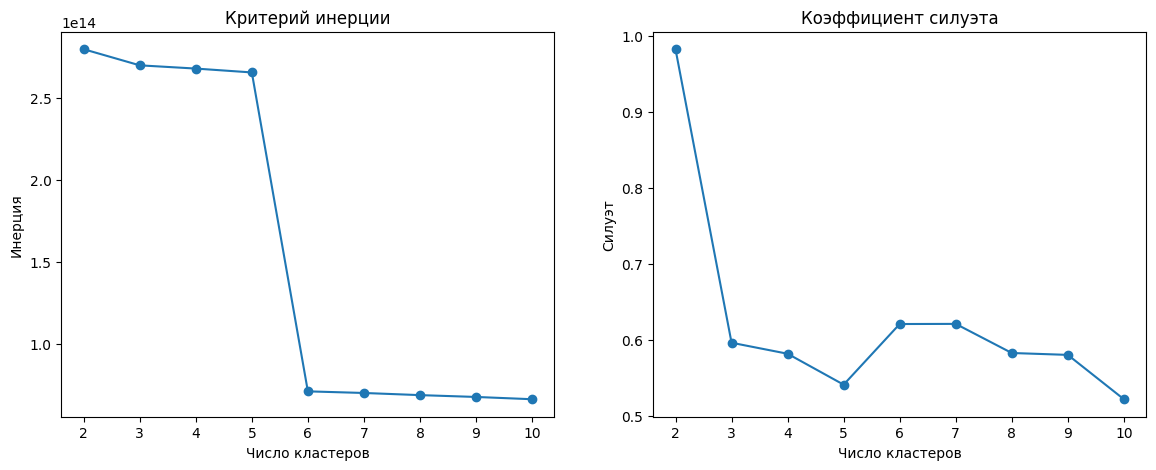

In [5]:
# Оценка инерции и коэффициента силуэта
from cuml.metrics.cluster import silhouette_score
from tqdm import tqdm  # Импорт библиотеки для отображения прогресса

# Оценка инерции и коэффициента силуэта
inertia = []
silhouette_scores = []
k_range = range(2, 11)

# tqdm для отображения прогресса
for k in tqdm(k_range, desc="Оценка числа кластеров"):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(reduced_data, kmeans.labels_))

# Построение графиков
plt.figure(figsize=(14, 5))

# График инерции
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Критерий инерции')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')

# График коэффициента силуэта
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт')

plt.show()

### Кластерный анализ

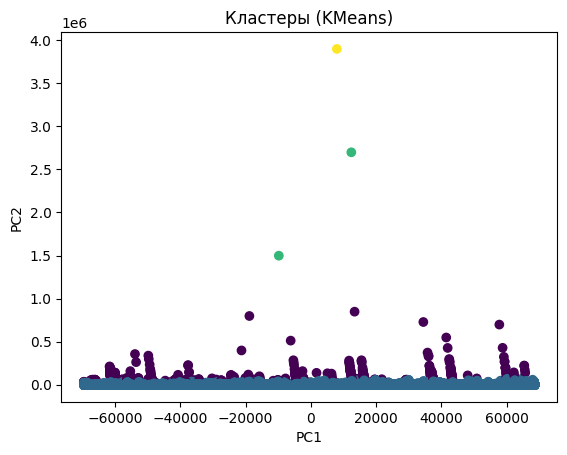

In [7]:
# Кластеризация с использованием KMeans
optimal_k = 4  # Выбираем на основе графиков
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(reduced_data)

# Преобразуем данные из cupy в numpy
reduced_data_np = reduced_data.get()
labels_np = labels.get()

# Визуализация кластеров
plt.scatter(reduced_data_np[:, 0], reduced_data_np[:, 1], c=labels_np, cmap='viridis')
plt.title('Кластеры (KMeans)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Оценка качества кластеризации

In [9]:
# Оценка коэффициента силуэта
silhouette = silhouette_score(reduced_data, labels)
print(f'Силуэт для кластеризации: {silhouette:.2f}')

Силуэт для кластеризации: 0.58
